사전구성

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #CIFAR 32x32 -> 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),  # CIFAR-100 평균
                         (0.2673, 0.2564, 0.2761))  # CIFAR-100 표준편차
])

In [3]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print("클래스 개수:", len(trainset.classes))    # 100
print("예시 클래스:", trainset.classes[:10])    # 앞 10개 클래스
print(trainset[0][0].shape)     #이미지 크기

클래스 개수: 100
예시 클래스: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
torch.Size([3, 224, 224])


모듈 구성

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channel=3, embedding_dim=768):
        super().__init__()

        assert image_size % patch_size == 0, "image size / patch size not dividale"
        self.image_size = image_size
        self.patch_size = patch_size
        self.grid_size = image_size // patch_size
        self.num_patches = self.grid_size * self.grid_size

        self.conv_layer = nn.Conv2d(in_channel, embedding_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x: torch.Tensor):
        x = self.conv_layer(x)
        x = x.flatten(2).transpose(1, 2)

        return x

In [5]:
class MSA(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embedding_dim, embedding_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x) # (B, N, 3C)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2] # (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * self.scale # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        out = attn @ v # (B, heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)

        return out

In [6]:
class EncodingBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_ratio, dropout):
        super().__init__()

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attention = MSA(embedding_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embedding_dim)
        
        hidden = embedding_dim * mlp_ratio
        self.fc1 = nn.Linear(embedding_dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, embedding_dim)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor):
        x = self.norm1(x)
        x = x + self.attention(x)
        x = self.norm2(x)
        x = x + self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

        return x


In [7]:
class myViT(torch.nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channel=3, num_classes=100, embedding_dim=768, depth=12, num_heads=12, mlp_ratio=4, dropout = 0.1):
        super().__init__()
        
        self.patch_embedding = PatchEmbedding(image_size, patch_size, in_channel, embedding_dim)
        num_patches = self.patch_embedding.num_patches

        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, embedding_dim))
        self.position_dropout = nn.Dropout(p = dropout)

        self.blocks = nn.ModuleList([EncodingBlock(embedding_dim, num_heads, mlp_ratio, dropout) for i in range(depth)])

        self.norm = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        class_token = self.class_token.expand(x.size(0), -1, -1)
        x = torch.cat((class_token, x), dim=1)
        x = x + self.position_embedding
        x = self.position_dropout(x)
        for block in self.blocks:
            x = block(x)
        x_cls = x[:, 0, :]
        logits = self.norm(x_cls)
        logits = self.head(logits)

        return logits

In [8]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = myViT(image_size=224, patch_size=32, in_channel=3, num_classes=100, embedding_dim=768, depth=12, num_heads=12, mlp_ratio=4, dropout = 0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.amp.GradScaler(device.type)
epochs = 20

학습 및 평가

In [9]:
from tqdm.auto import tqdm
import time
#tqdm 테스트
for i in tqdm(range(50), desc="smoke test", dynamic_ncols=True):
    time.sleep(0.01)

smoke test:   0%|          | 0/50 [00:00<?, ?it/s]

In [10]:


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()

    # 평가도 진행률 보이게
    pbar = tqdm(loader, desc="Val", leave=False)
    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        pred = logits.argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()
        loss_sum += loss.item() * y.size(0)

        cur_loss = loss_sum / total
        cur_acc  = correct / total * 100
        pbar.set_postfix(loss=f"{cur_loss:.4f}", acc=f"{cur_acc:.2f}%")

    return loss_sum / total, correct / total

# ============================================================
# 학습 루프 (진행률/ETA/속도/메모리 사용량 표시)
# ============================================================

best_acc = 0.0
os.makedirs('checkpoints', exist_ok=True)

for epoch in range(1, epochs+1):
    model.train()
    total, correct, run_loss = 0, 0, 0.0

    start = time.time()
    # tqdm 진행바: 전체 배치 수 기준
    pbar = tqdm(trainloader, desc=f"Train {epoch:02d}/{epochs}", leave=False)

    for i, (x, y) in enumerate(pbar, 1):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # 통계 갱신
        run_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()

        # 현재 스텝 지표
        train_loss = run_loss / total
        train_acc  = correct / total * 100.0
        cur_lr     = scheduler.get_last_lr()[0] if hasattr(scheduler, "get_last_lr") else optimizer.param_groups[0]["lr"]

        # 속도/메모리(선택)
        elapsed = time.time() - start
        ips = total / max(elapsed, 1e-9)  # images/sec
        if device.type == 'cuda':
            mem_mb = torch.cuda.memory_allocated() / (1024**2)
            mem_txt = f"{mem_mb:.0f}MB"
        else:
            mem_txt = "CPU"

        # 진행바 우측에 지표 출력
        pbar.set_postfix({
            "loss": f"{train_loss:.4f}",
            "acc": f"{train_acc:.2f}%",
            "lr": f"{cur_lr:.5f}",
            "ips": f"{ips:.0f}/s",
            "mem": mem_txt
        })

    # 스케줄러 스텝 (에폭 끝)
    scheduler.step()

    # 에폭 요약 출력
    val_loss, val_acc = evaluate(model, testloader, device)
    print(f"[{epoch:02d}/{epochs}] "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}% | "
          f"val_loss={val_loss:.4f} val_acc={val_acc*100:.2f}% | "
          f"lr={scheduler.get_last_lr()[0]:.5f}")

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc/100.0)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # 베스트 저장 (파일명 수정: vit)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "checkpoints/best_vit_cifar100.pt")

print(f"Best val_acc: {best_acc*100:.2f}%")

Train 01/20:   0%|          | 0/391 [00:09<?, ?it/s]

Val:   0%|          | 0/79 [00:07<?, ?it/s]

[01/20] train_loss=4.0797 train_acc=7.23% | val_loss=3.7784 val_acc=11.26% | lr=0.00010


Train 02/20:   0%|          | 0/391 [00:08<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[02/20] train_loss=3.6107 train_acc=14.18% | val_loss=3.5539 val_acc=15.68% | lr=0.00010


Train 03/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[03/20] train_loss=3.2722 train_acc=20.12% | val_loss=3.1562 val_acc=23.06% | lr=0.00010


Train 04/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[04/20] train_loss=2.9931 train_acc=25.04% | val_loss=3.0085 val_acc=24.87% | lr=0.00010


Train 05/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[05/20] train_loss=2.7451 train_acc=30.00% | val_loss=2.8134 val_acc=29.60% | lr=0.00010


Train 06/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[06/20] train_loss=2.5094 train_acc=34.90% | val_loss=2.7539 val_acc=31.37% | lr=0.00010


Train 07/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:09<?, ?it/s]

[07/20] train_loss=2.2580 train_acc=40.30% | val_loss=2.7080 val_acc=33.02% | lr=0.00010


Train 08/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[08/20] train_loss=1.9844 train_acc=46.52% | val_loss=2.6694 val_acc=34.59% | lr=0.00009


Train 09/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[09/20] train_loss=1.7019 train_acc=53.03% | val_loss=2.5939 val_acc=36.27% | lr=0.00009


Train 10/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:09<?, ?it/s]

[10/20] train_loss=1.3955 train_acc=60.88% | val_loss=2.6861 val_acc=35.75% | lr=0.00009


Train 11/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[11/20] train_loss=1.0918 train_acc=68.78% | val_loss=2.7078 val_acc=36.65% | lr=0.00009


Train 12/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[12/20] train_loss=0.7854 train_acc=77.41% | val_loss=2.8294 val_acc=36.70% | lr=0.00009


Train 13/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[13/20] train_loss=0.5337 train_acc=84.74% | val_loss=2.9942 val_acc=37.71% | lr=0.00008


Train 14/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:09<?, ?it/s]

[14/20] train_loss=0.3613 train_acc=89.83% | val_loss=3.1821 val_acc=36.10% | lr=0.00008


Train 15/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[15/20] train_loss=0.2633 train_acc=92.52% | val_loss=3.2812 val_acc=37.03% | lr=0.00008


Train 16/20:   0%|          | 0/391 [00:21<?, ?it/s]

Val:   0%|          | 0/79 [00:09<?, ?it/s]

[16/20] train_loss=0.2203 train_acc=93.60% | val_loss=3.4242 val_acc=37.14% | lr=0.00008


Train 17/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[17/20] train_loss=0.1880 train_acc=94.65% | val_loss=3.4421 val_acc=37.44% | lr=0.00007


Train 18/20:   0%|          | 0/391 [00:11<?, ?it/s]

Val:   0%|          | 0/79 [00:09<?, ?it/s]

[18/20] train_loss=0.1576 train_acc=95.38% | val_loss=3.5200 val_acc=37.33% | lr=0.00007


Train 19/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[19/20] train_loss=0.1322 train_acc=96.17% | val_loss=3.6694 val_acc=37.77% | lr=0.00007


Train 20/20:   0%|          | 0/391 [00:10<?, ?it/s]

Val:   0%|          | 0/79 [00:08<?, ?it/s]

[20/20] train_loss=0.1182 train_acc=96.55% | val_loss=3.7422 val_acc=36.78% | lr=0.00007
Best val_acc: 37.77%


그래프

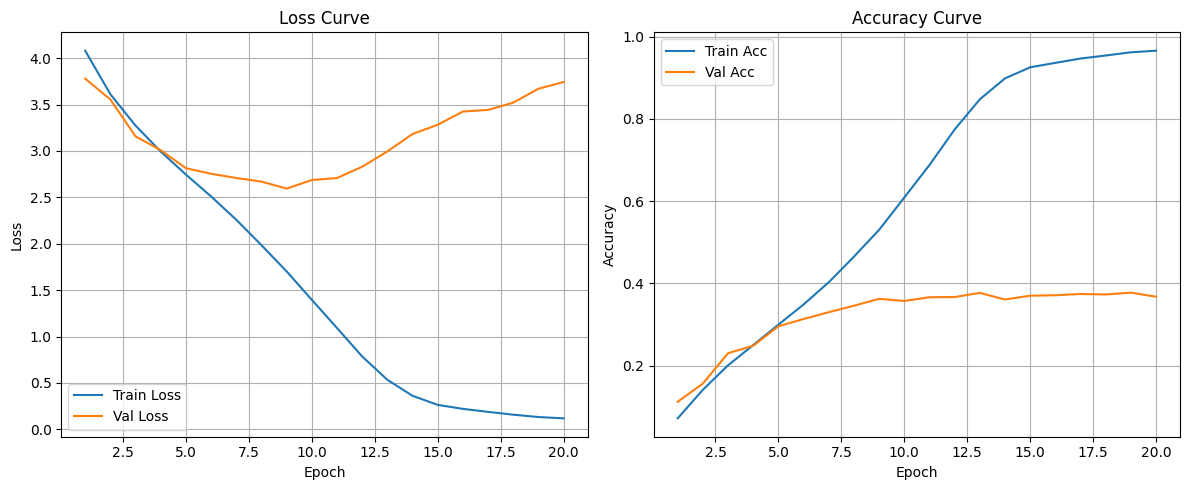

In [11]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs+1)

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label="Train Loss")
plt.plot(epochs_range, val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label="Train Acc")
plt.plot(epochs_range, val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()